In [1]:
#import libraries
library('ggplot2')
library('forecast')
library('tseries')
library('scales')

In [2]:
hourly_data = read.csv('hour.csv', header=TRUE, stringsAsFactors=FALSE)

In [3]:
hourly_data$Date = as.Date(hourly_data$dteday)

In [4]:
hourly_data$DateTime = as.POSIXct(paste(hourly_data$dteday, hourly_data$hr), format="%Y-%m-%d %H")

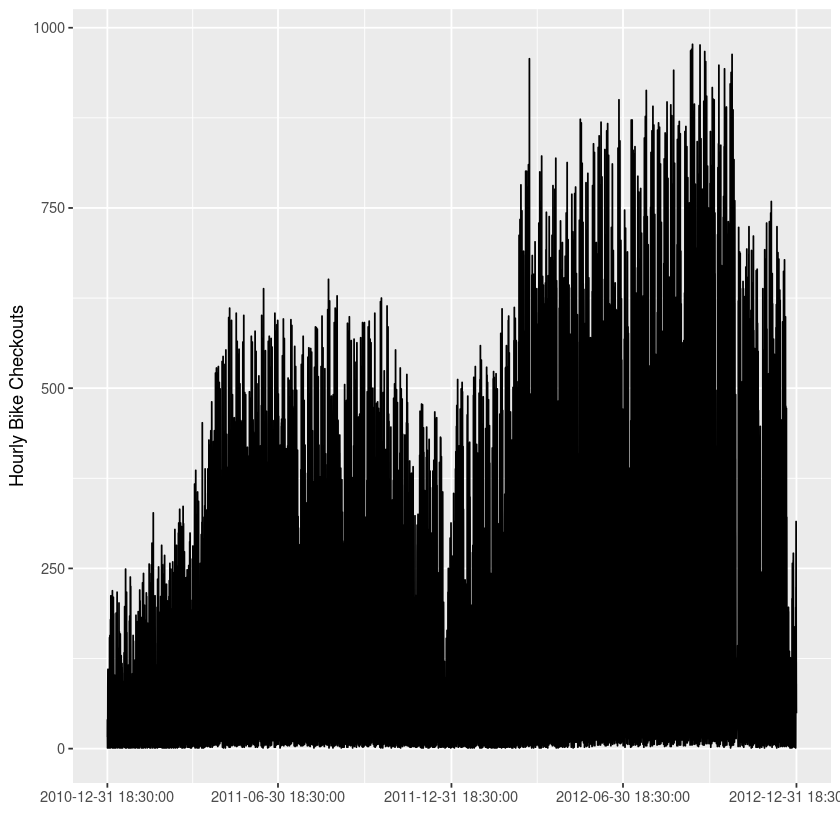

In [5]:
ggplot(hourly_data, aes(DateTime, cnt)) + geom_line() + ylab("Hourly Bike Checkouts") + xlab("") + scale_x_datetime(labels = date_format("%Y-%m-%d %H:%M:%S"))

In [6]:
#Cleaning UP
#Interpolation for missiong data
count_ts = ts(sqrt(hourly_data[, c('cnt')]))
hourly_data$clean_cnt = tsclean(count_ts)

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


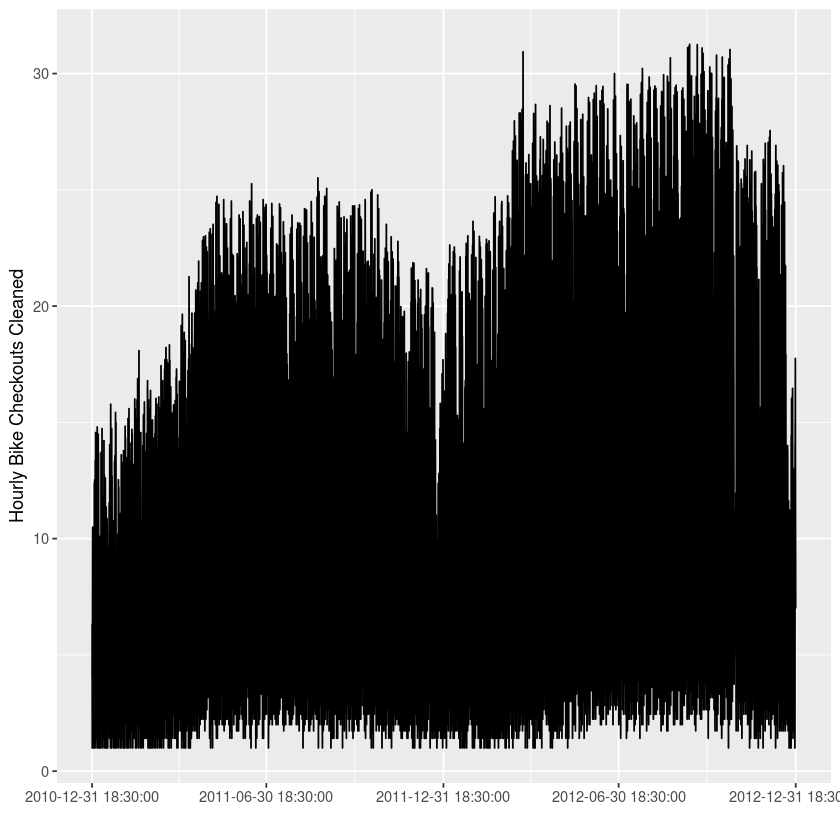

In [7]:
ggplot(hourly_data, aes(DateTime,clean_cnt)) + geom_line() + ylab("Hourly Bike Checkouts Cleaned") + xlab("") + scale_x_datetime(labels = date_format("%Y-%m-%d %H:%M:%S"))

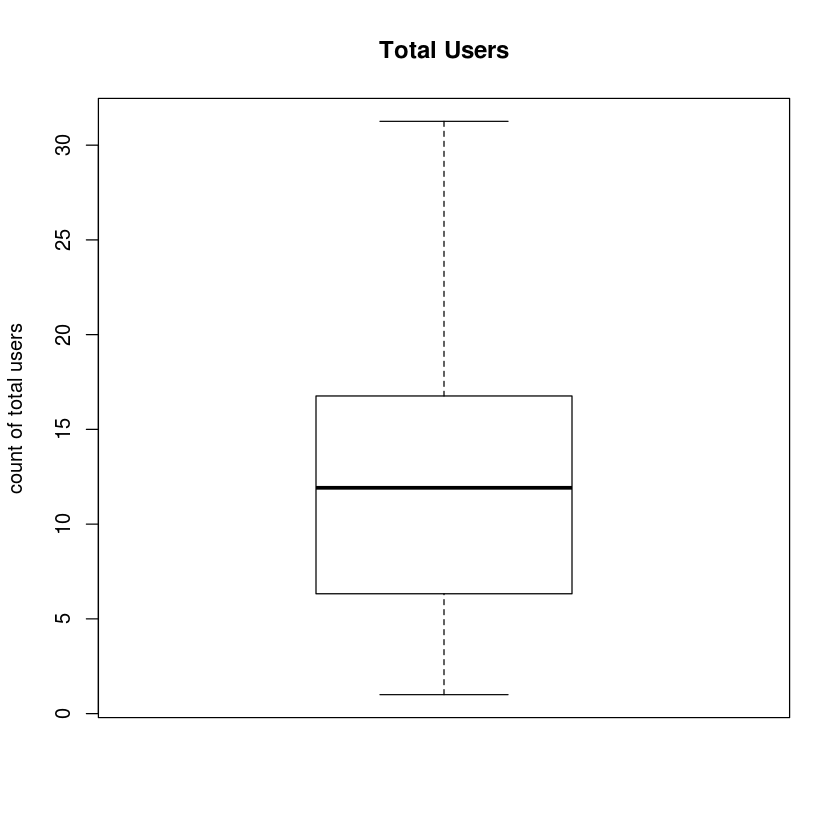

In [8]:
boxplot(hourly_data$clean_cnt, ylab = "count of total users", main = "Total Users")

In [9]:
#Moving AVG
hourly_data$cnt_ma = ma(hourly_data$clean_cnt, order=24)
hourly_data$cnt_ma7 = ma(hourly_data$clean_cnt, order=24*7)
hourly_data$cnt_ma30 = ma(hourly_data$clean_cnt, order=30*24)

In [10]:
hourly_data_sub = hourly_data

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


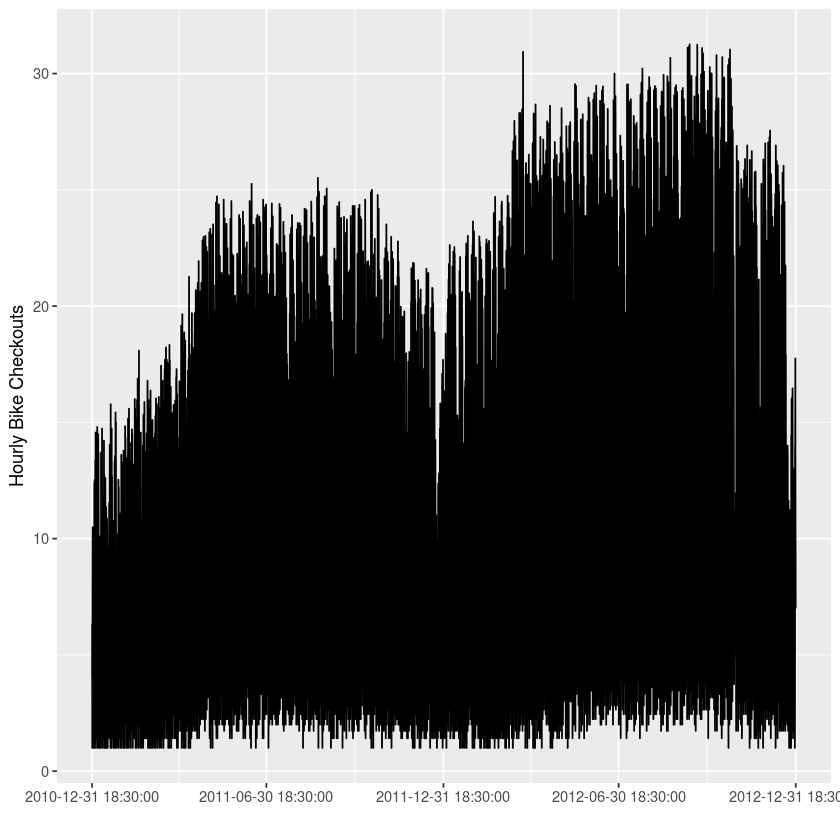

In [11]:
ggplot(hourly_data_sub, aes(DateTime, clean_cnt)) + geom_line() + ylab("Hourly Bike Checkouts") + xlab("") + scale_x_datetime(labels = date_format("%Y-%m-%d %H:%M:%S"))

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Warning message:
“Removed 24 rows containing missing values (geom_path).”Warning message:
“Removed 168 rows containing missing values (geom_path).”Warning message:
“Removed 720 rows containing missing values (geom_path).”

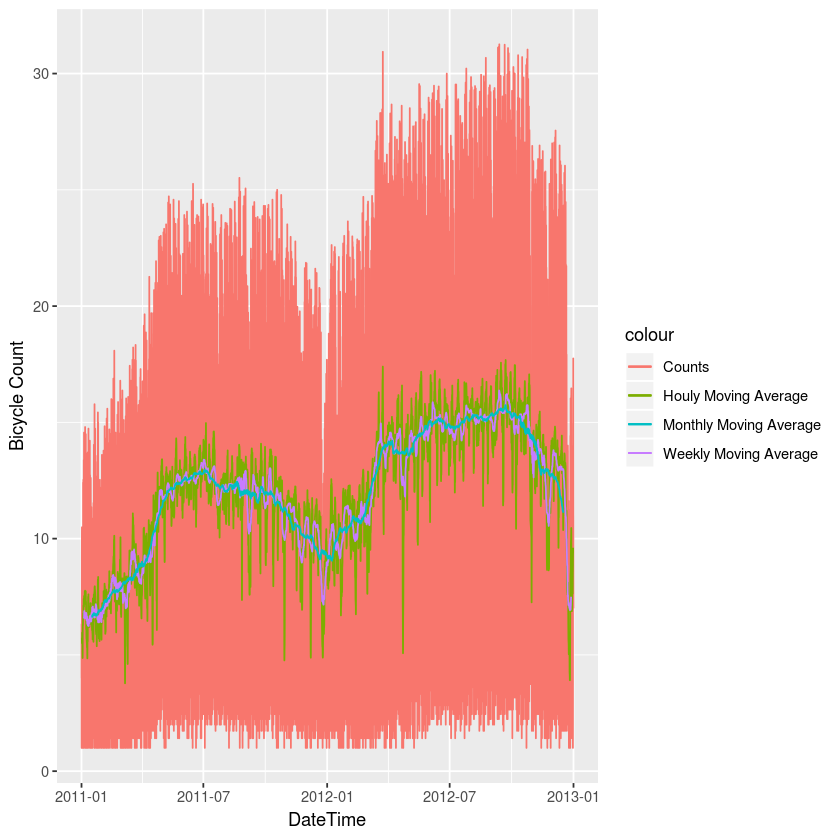

In [13]:
ggplot() +
geom_line(data = hourly_data_sub, aes(x = DateTime, y = clean_cnt, colour = "Counts")) +
geom_line(data = hourly_data_sub, aes(x = DateTime, y = cnt_ma, colour = "Houly Moving Average")) +
geom_line(data = hourly_data_sub, aes(x = DateTime, y = cnt_ma7, colour = "Weekly Moving Average")) +
geom_line(data = hourly_data_sub, aes(x = DateTime, y = cnt_ma30, colour = "Monthly Moving Average")) +
ylab('Bicycle Count')

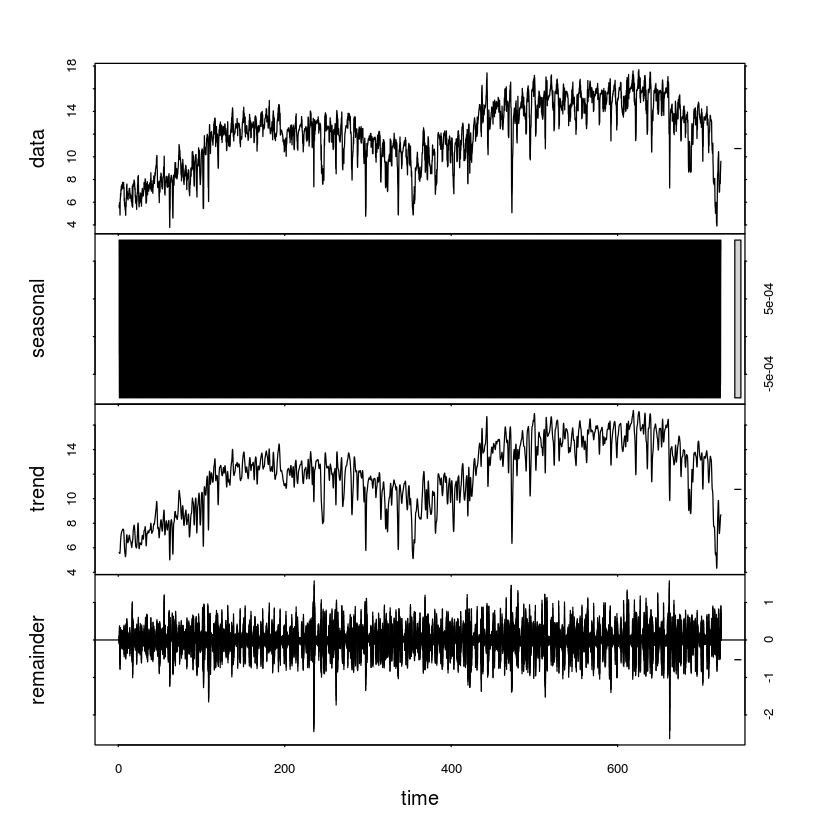

In [14]:
#create a time series object
count_ma = ts(na.omit(hourly_data$cnt_ma), frequency=24)
#decompose the time series object using loess(Local Polynomial Regression Fitting)
decomp = stl(count_ma, s.window="periodic")
# Returns seasonally adjusted data constructed by removing the seasonal component.
deseasonal_cnt = seasadj(decomp)
plot(decomp)

In [15]:
adf.test(count_ma, alternative = "stationary")

Warning message in adf.test(count_ma, alternative = "stationary"):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  count_ma
Dickey-Fuller = -7.4031, Lag order = 25, p-value = 0.01
alternative hypothesis: stationary


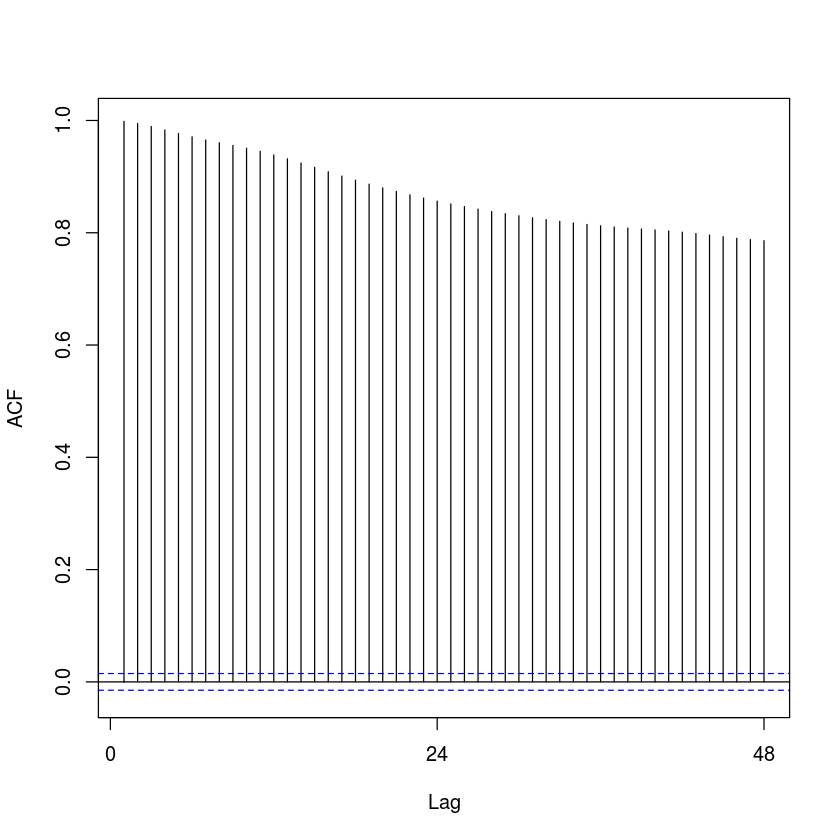

In [16]:
Acf(count_ma, main='')

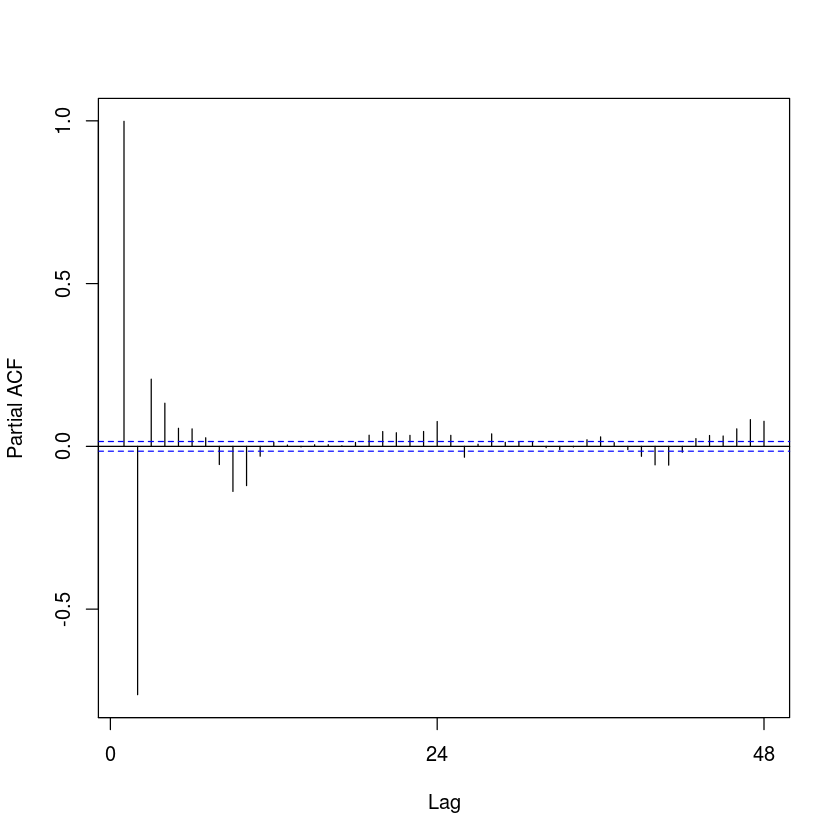

In [17]:
Pacf(count_ma, main='')

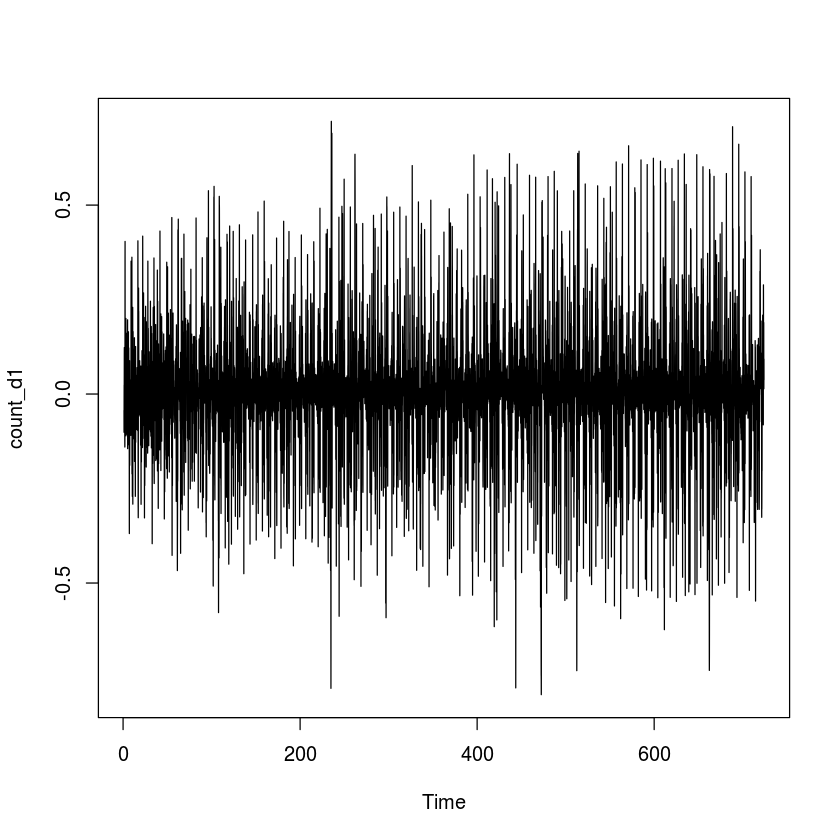

In [19]:
count_d1 = diff(deseasonal_cnt, differences = 1) #consecutive differences to remove seasonality (1st order)
plot(count_d1)

In [20]:
adf.test(count_d1, alternative = "stationary")

Warning message in adf.test(count_d1, alternative = "stationary"):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  count_d1
Dickey-Fuller = -32.188, Lag order = 25, p-value = 0.01
alternative hypothesis: stationary


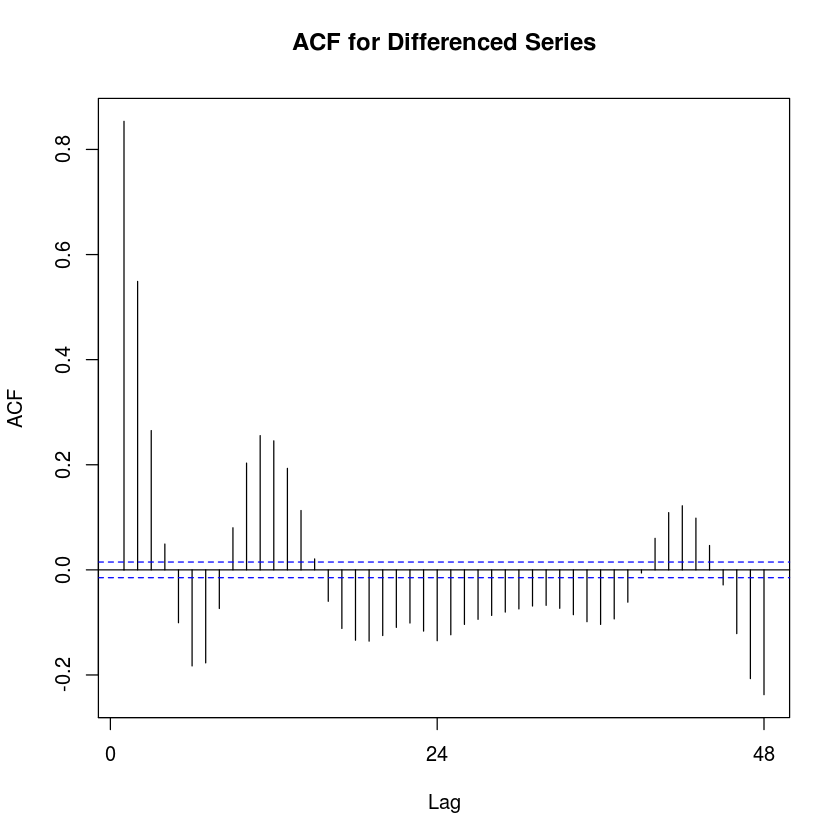

In [21]:
Acf(count_d1, main='ACF for Differenced Series')

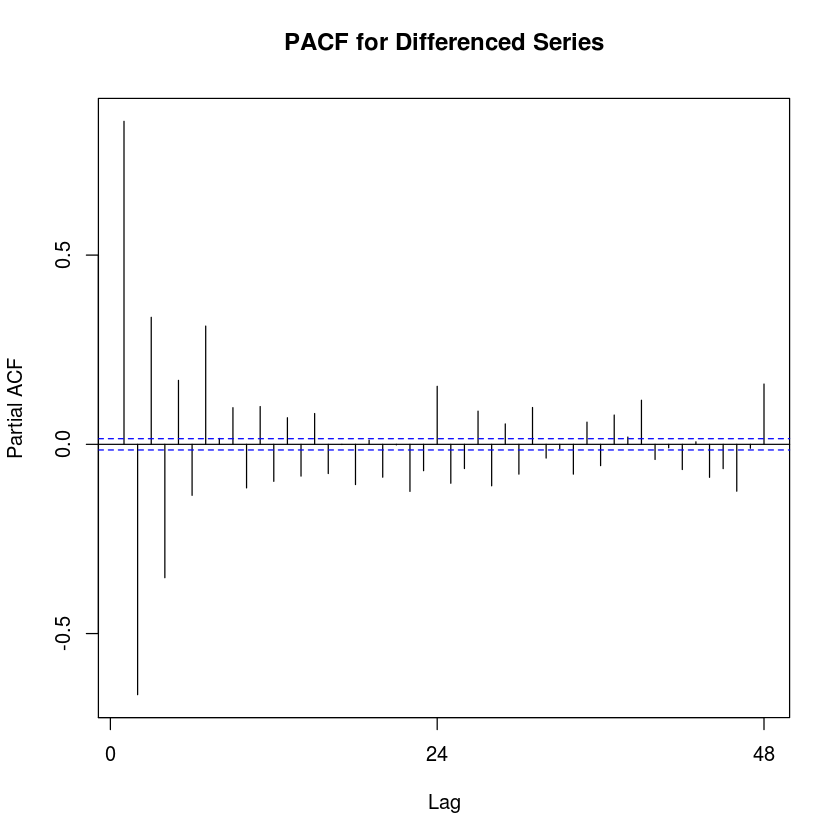

In [22]:
Pacf(count_d1, main='PACF for Differenced Series')

In [23]:
fit = arima(deseasonal_cnt,order = c(1,1,1),seasonal = list(order = c(0, 0, 0), period = 30*24))

In [24]:
fit


Call:
arima(x = deseasonal_cnt, order = c(1, 1, 1), seasonal = list(order = c(0, 0, 
    0), period = 30 * 24))

Coefficients:
         ar1     ma1
      0.7805  0.9775
s.e.  0.0047  0.0010

sigma^2 estimated as 0.002398:  log likelihood = 27723.21,  aic = -55440.43

In [25]:
fcast = forecast(fit, h=30*24)

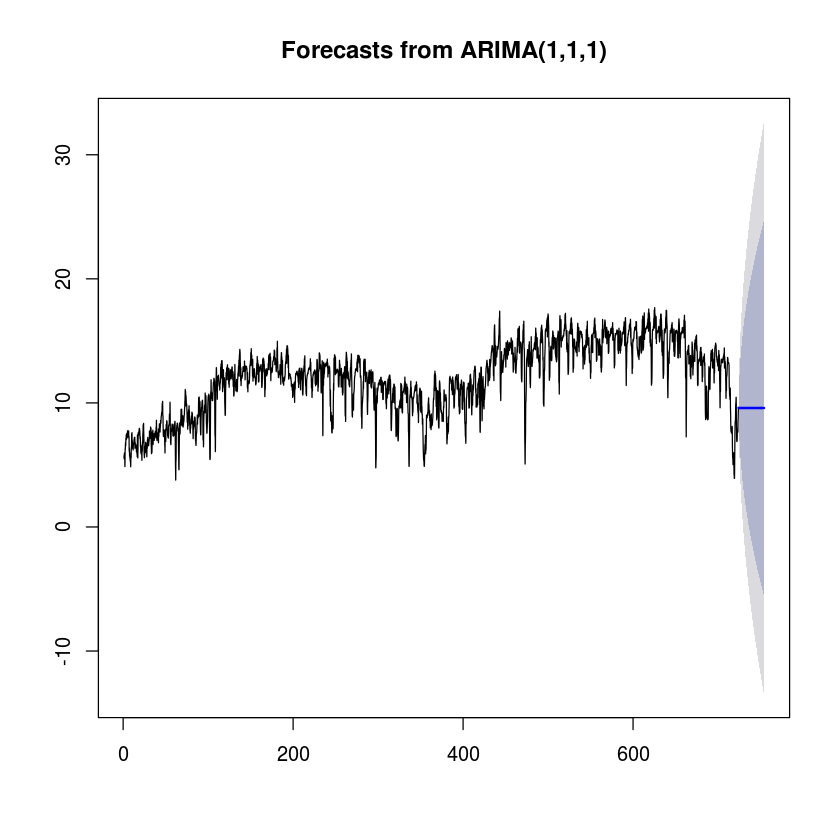

In [26]:
plot(fcast)

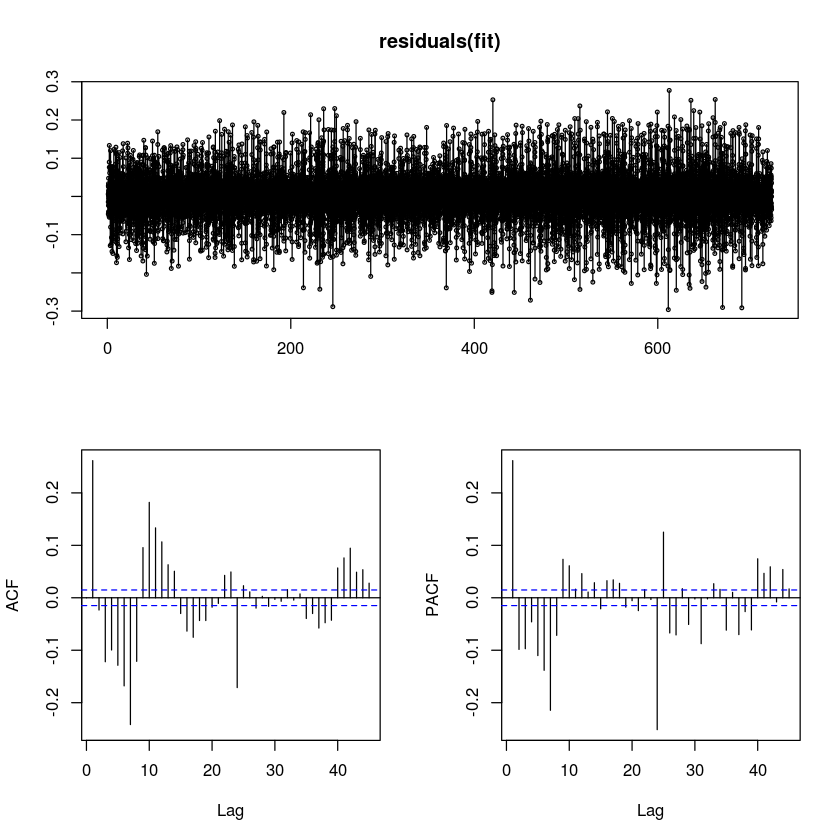

In [27]:
tsdisplay(residuals(fit), lag.max=45)

In [28]:
fit1 = auto.arima(deseasonal_cnt, seasonal=FALSE, max.p=30, max.d=30, max.q=30)

In [29]:
fit1

Series: deseasonal_cnt 
ARIMA(4,1,4) with drift 

Coefficients:
         ar1     ar2     ar3      ar4     ma1     ma2      ma3      ma4  drift
      0.4531  0.2742  0.0472  -0.2390  1.5452  0.5704  -0.2096  -0.2151  2e-04
s.e.  0.2864  0.0898  0.2909   0.1872  0.2819  0.5211   0.1440   0.1042  2e-03

sigma^2 estimated as 0.002104:  log likelihood=28861.79
AIC=-57703.59   AICc=-57703.57   BIC=-57625.97

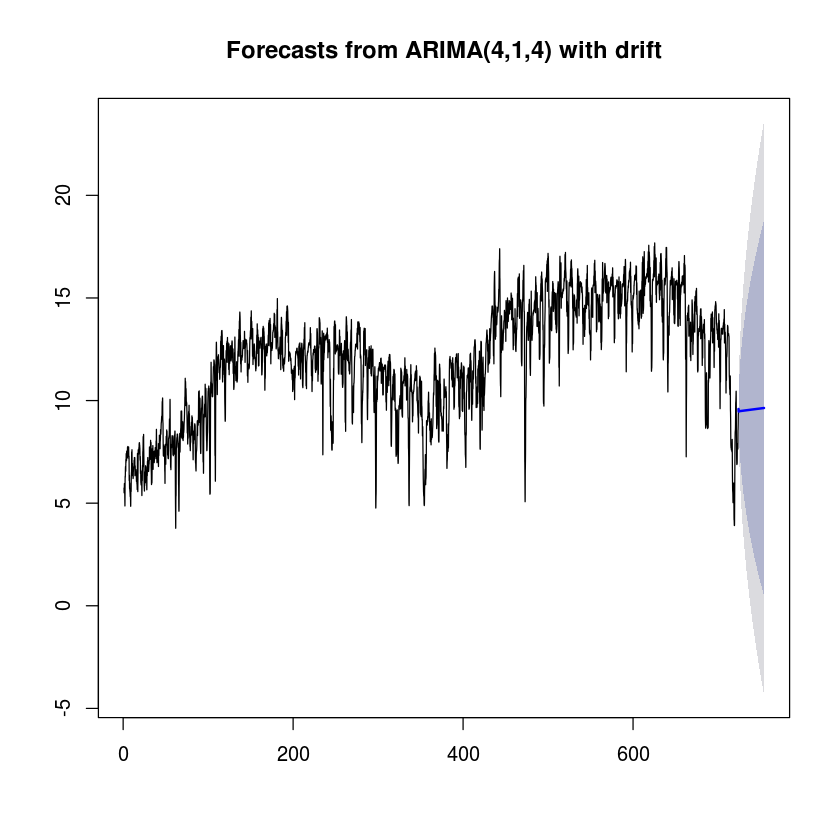

In [30]:
fcast1  = forecast(fit1, h=30*24)
plot(fcast1)

In [33]:
fit = arima(deseasonal_cnt,order = c(4,1,24))

Warning message in arima(deseasonal_cnt, order = c(4, 1, 24)):
“possible convergence problem: optim gave code = 1”

In [34]:
fit


Call:
arima(x = deseasonal_cnt, order = c(4, 1, 24))

Coefficients:
          ar1     ar2     ar3     ar4     ma1     ma2     ma3      ma4      ma5
      -0.1430  0.2400  0.4487  0.3135  2.2120  1.9531  0.5938  -0.8469  -1.4474
s.e.   0.0239  0.0102  0.0126  0.0145  0.0231  0.0522  0.0493   0.0329   0.0347
          ma6      ma7      ma8      ma9    ma10    ma11    ma12    ma13
      -1.3086  -1.0906  -1.0307  -0.7386  0.0127  0.7959  1.0886  0.8405
s.e.   0.0347   0.0326   0.0334   0.0358  0.0341  0.0315  0.0362  0.0405
        ma14    ma15     ma16     ma17     ma18     ma19     ma20     ma21
      0.4522  0.1639  -0.1512  -0.5764  -0.8451  -0.7264  -0.3915  -0.2074
s.e.  0.0375  0.0306   0.0293   0.0301   0.0336   0.0353   0.0307   0.0294
         ma22    ma23    ma24
      -0.1314  0.2710  0.3005
s.e.   0.0338  0.0331  0.0148

sigma^2 estimated as 0.001559:  log likelihood = 31448.28,  aic = -62838.55

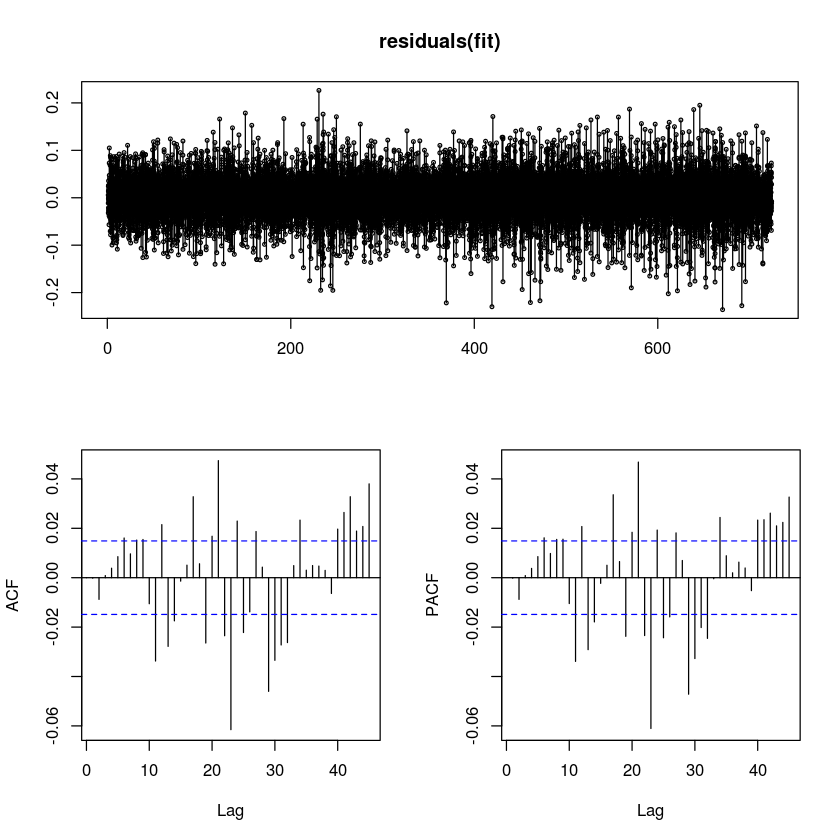

In [35]:
tsdisplay(residuals(fit), lag.max=45)

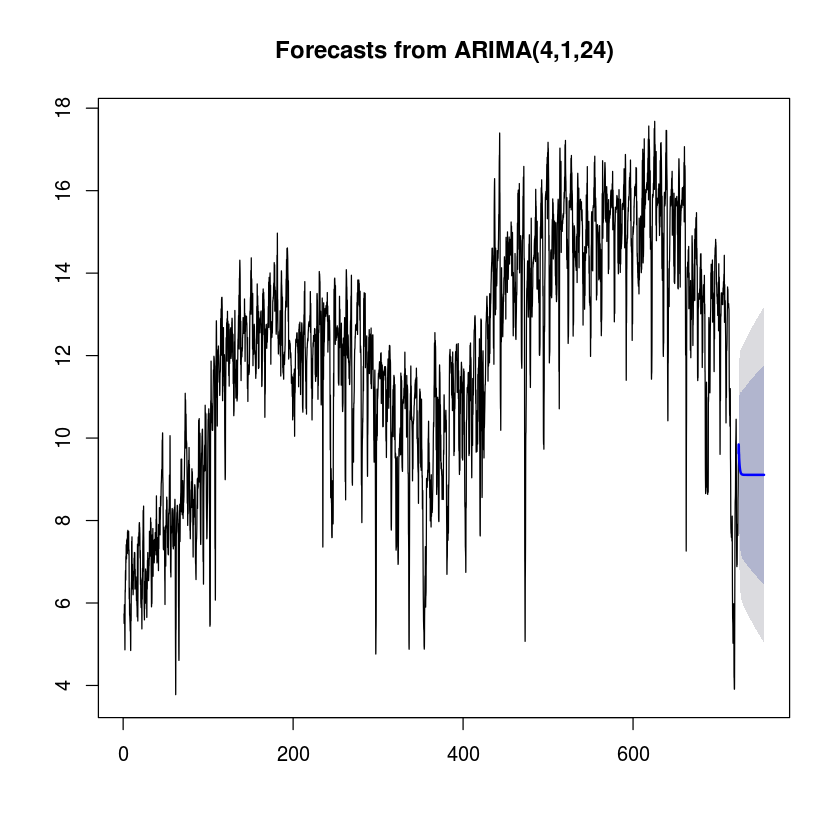

In [36]:
fcast2  = forecast(fit, h=30*24)
plot(fcast2)